# Battery Optimization Problem: standard version

This version adds some complications to the simple optimization problem. Here we build an integer program and include the regulation market, reserves market and simplified cycling cost. This stays as an hourly time granularity but future work will convert it into 5-min intervals.

The battery operator's objective is to maximize its profit by optimizing its participation in the energy, reserves, and regulation markets over the operating day. The participation rules for each market become very important for understanding the battery's constraints and possible decisions. Here we make some simpliyfing assumptions about the design of these markets.

Energy Market: A battery is dispatched in the real-time energy market by either discharging ($d_{t}$) or charging ($c_{t}$) and receives/pays a price of $LMP_{t}$. In this set up we will make the problem an integer program in order to allow for negative expected LMPs. In the simplified version, we had assumed non-negative LMPs; this assumption meant that the optimal solution of the LP would never yield an outcome where the battery discharged and charged in the same interval $t$ ($d_{t}>0$ and $c_{t}>0$). But once we allow for negative LMPs, then we must introduce binary variables $D_{t}$ and $C_{t}$, which indicate whether the battery is either discharging or charging.

Regulation Market: Assume that a battery receives ($RegPrice_{t}$) for each MWh of capacity it clears in the regulation market in a given hour. That is, if a battery clears 1 MW of capacity for regulation in a single hour, it receives $RegPrice_{t}/12$ in revenue. This prices is intended to encompass all revenues received in (e.g., capability or mileage) and doesn't differentiate between reg-up and reg-down services. We further assume batteries are selected for the regulation market at the top of every hour and once a battery has committed some capacity to regulation, those MWs must be committed to regulation until the next hour. Additionally, regulation is assumed to have a zero net impact on the battery's state of charge. For exmaple, if a battery began providing regulation when it had a 10MWh SOC, its move around based on the regulation signals but would end the interval at 10MWh SOC.

Reserves Market: The battery can provide spinning reserves, which are co-optimized with energy, and receives a price of $Res_Price_{t}$ per MWh. Reserves must be sustained for 1 hour, so the reserves a battery provides cannot exceeds its available MWh energy level.

The operator has a forecast of hourly energy market prices ($LMP_{t}$), regulation prices ($RegPrice_{t}$), and spinning reserves prices ($ResPrice_{t}$). 

The battery has a maximum energy storage capacity of $S_{max}$ and a minimum energy capacity of $S_{min}$, which may be used to avoid a full discharge of the battery. The maximum charge and discharge rate is $\delta$ and one-way efficiency is $\eta$. 

The battery incurs a cycling cost of $u$ for evey MWh charged or discharged. This cycling cost represents the cost associated with degradation of the battery over time as it is charged and discharged. This degradation shortens the battery's life and results in lost future revenue or additional costs to replace the battery.

The battery begins the day at a state-of-charge of ($S_{0}$).

\begin{align} max \sum_{t=1}^{T} \ (LMP_{t}-v_{t})*d_{t} - LMP_{t}*c_{t} + RegPrice_{t}*Reg_{t} + ResPrice_{t}*Res_{t} \\
    s.t. \\
    0 \le c_{t} \le \delta *C_{t}  \\
    0 \le d_{t} \le \delta *D_{t} \\
    0 \le Reg_{t} \le \delta \\
     Res_{t} \le S_{t-1} \\
    d_{t} + c_{t} + Reg_{t} \le \delta \\
    d_{t} - c_{t} + Reg_{t} + Res_{t} \le \delta \\
    \eta * c_{t} - (1/\eta)*d_{t} - S_{t} + S_{t-1} = 0 \\
    S_{min} \le S_{t} \le S_{max} \\
    S_{0}=0 \\
    D_{t} + C_{t} \le 1 \\
    D_{t}, C_{t} \in {0,1}
\end{align}

Decision variables:
- $d_{t}$ rate of discharge in interval t (MW)
- $c_{t}$ rate of charge in interval t (MW)
- $D_{t}$ =1 if discharging in interval t; =0 otherwise
- $C_{t}$ =1 if charging in interval t; =0 otherwise
- $Reg_{t}$ capacity committed to regulation in interval t (MW)
- $Res_{t}$ reserves provided in interval t (MW)

State variable: $S_{t}$ battery state of charge at the end of interval t (MWh)

Parameters:
- $LMP_{t}$ forecasted LMPs (\$/MWh)
- $RegPrice_{t}$ forecasted regulation clearing prices (\$/MWh)
- $ResPrice_{t}$ forecasted reserve clearing prices (\$/MWh)
- $\delta$ maximum rate of charge/discharge (MW)
- $\eta$ one-way efficiency losses (\%)
- $K$ maximum state of charge (MWh)
- $v$ cycling cost (\$/MWh)


| Constraint Name | Constraint | Explanation|
|-----------------|------------|------------|
|Charge Limit | $0 \le c_{t} \le \delta * C_{t}$ | Battery charging rate is bounded between the minimum and maximum rates|
|Discharge Limit | $0 \le d_{t} \le \delta * D_{t}$ | Battery discharging rate is bounded between the minimum and maximum rates|
|Regulation Limit | $0 \le Reg_{t} \le \delta$ | The amount of MWs a battery can commit to regulation is limited by max charge/discharge rate|
|Reserves Limit | $Res_{t} \le S_{t-1}$ | Reserves provided cannot exceed a battery's MWh SOC at the beginning of the interval; this ensurse 1-hour sustainability of reserves |
|Limits on Energy and Regulation | $d_{t} + c_{t} + Reg_{t} \le \delta$ | The amount of MWs that can be committed to energy and regulation is limited by the max discharge rate |
|Limits on Energy and Regulation | $d_{t} - c_{t} + Reg_{t} + Res_{t} \le \delta$ | The amount of MWs that can be committed to energy and reserves is limited by the max discharge rate|
|Flow balance equation | $\eta * c_{t} - (1/\eta)*d_{t} - S_{t} + S_{t-1} = 0$ | The SOC charge at the end of an interval equals the beginning SOC less energy discharged, plus energy charged (adjusting for efficiency losses)|
|SOC Limits | $ S_{min} \le S_{t} \le S_{max}$ | The lower and upper bounds for the state of charge|
|Either Charging or Discharging | $ D_{t} + C_{t} \le 0$ | Battery cannot be charging and discharging in the same interval|

In [36]:
# get necessary libraries
import numpy as np
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# import price data we use for examples
prices_df = pd.read_csv("prices.csv")
prices_df = prices_df.sort_values(by=['day','hour'])

In [45]:
# parameter inputs
# hours of optimization horizon
t_max = 24
# pick which example day to use
example_day = 3
# prices
prices_e = prices_df[prices_df['day']==example_day]['price_e'].to_list()
prices_reg = prices_df[prices_df['day']==example_day]['price_reg'].to_list()
prices_res = prices_df[prices_df['day']==example_day]['price_res'].to_list()
# battery maximum charge/discharge rates
w = 5
eff = 0.95
# battery minimum/maximum energy capacity
S_min = 0
S_max = 10
# battery starting energy level
SOC_begin = 0
# cycling cost- fixed $ per MWh discharged
v = 5

In [46]:
# set up the optimization problem
if 'battery_prob' in locals(): del battery_prob
battery_prob = LpProblem("BatteryOptimization",LpMaximize)
# decision variables
charge_var = LpVariable.dicts("c", range(1,t_max+1),0,w) #upper/lower bounds on charging
discharge_var = LpVariable.dicts("d", range(1,t_max+1),0,w) #upper/lower bounds on discharging
charge_bin = LpVariable.dicts("Cbin", range(1,t_max+1),0,1, cat="Binary") #charging binary
discharge_bin = LpVariable.dicts("Dbin", range(1,t_max+1),0,1, cat="Binary") #discharging binary
soc_var = LpVariable.dicts("SOC", range(1,t_max+1),S_min,S_max) #upper/lower bounds on SOC
reg_var = LpVariable.dicts("reg", range(1,t_max+1),0,w) #upper/lower bounds on regulation
res_var = LpVariable.dicts("res", range(1,t_max+1),0,2*w) #upper/lower bounds on reserves

In [47]:
# define the objective function
p_e = {i+1:(prices_e[i]) for i in range(0,t_max)}
p_reg = {i+1:(prices_reg[i]) for i in range(0,t_max)}
p_res = {i+1:(prices_res[i]) for i in range(0,t_max)}
# setup optimization problem
battery_prob += (
    lpSum([-1*p_e[j] * charge_var[j] for j in range(1,t_max+1)]+
         [(p_e[j]-v) * discharge_var[j] for j in range(1,t_max+1)]+
         [p_reg[j] * reg_var[j] for j in range(1,t_max+1)]+
         [p_res[j] * res_var[j] for j in range(1,t_max+1)]),
    'Battery Profit')

In [48]:
#add constraints
for i  in range(1,t_max+1):
    battery_prob += lpSum(eff*charge_var[i] - (1/eff)*discharge_var[i] - soc_var[i] + (SOC_begin if i==1 else soc_var[i-1])) == 0, 'flow_bal_'+str(i) # flow balance equation 
    battery_prob += lpSum(res_var[i] - (SOC_begin if i==1 else soc_var[i-1])) <= 0, 'res_1hr_'+str(i) #1hr sustainability reserves
    battery_prob += lpSum(charge_var[i] + discharge_var[i] + reg_var[i]) <= w, 'Energy_Reg'+str(i)  #energy and reg combined limits
    battery_prob += lpSum(-charge_var[i] + discharge_var[i] + reg_var[i] + res_var[i]) <= w, 'Energy_Reg_Res'+str(i)  #energy, reg, res combined limits
    battery_prob += lpSum(charge_var[i] - charge_bin[i]*w) <= 0, 'charge_ub'+str(i)
    battery_prob += lpSum(discharge_var[i] - discharge_bin[i]*w) <= 0, 'discharge_ub'+str(i)
    battery_prob += lpSum(charge_bin[i] + discharge_bin[i]) <= 1, 'charge_discharge'+str(i)

In [17]:
# uncomment to show the optimization problem
#print(battery_prob)

In [49]:
# solve linear program
battery_prob.solve()
print('Status: ',LpStatus[battery_prob.status])
print('Optimal Objective Function Value:',value(battery_prob.objective))

Status:  Optimal
Optimal Objective Function Value: 40911.681929338396


In [50]:
opt_df = pd.DataFrame(columns=['var_name','var_val'])
for x in battery_prob.variables():
    var_dict = {'var_name':x.name,
                'var_val':x.varValue}
    var_df = pd.DataFrame(var_dict, index=[0])
    opt_df = var_df if opt_df.empty else pd.concat([opt_df,var_df], ignore_index=True)
opt_df[['var', 'time']] = opt_df['var_name'].str.split("_", expand=True)
opt_df = opt_df.drop(['var_name'], axis=1)
opt_df = opt_df.pivot(columns='var',values='var_val', index='time')
opt_df = opt_df.reset_index()
opt_df['time'] = opt_df['time'].astype(int)
opt_df = opt_df.sort_values(by=['time'])
opt_df.reset_index(drop=True, inplace=True)
opt_df['c'] = opt_df['c'] *-1 
opt_df = opt_df.rename(columns={'c':'charge_mw','Cbin':'charging_flag','d':'discharge_mw','Dbin':'discharging_flag','reg':'regulation','res':'reserves'})

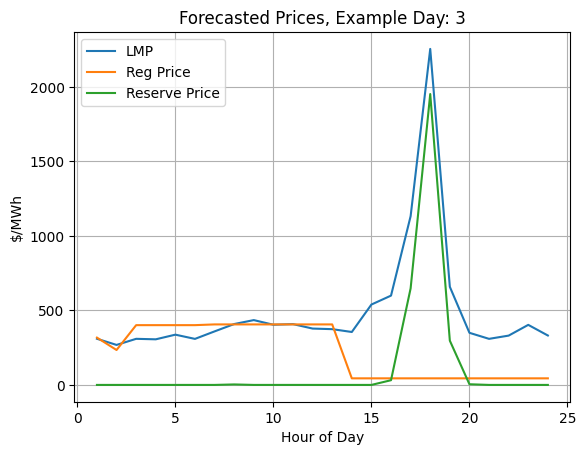

In [51]:
# plot forecasted prices
prices_df[prices_df['day']==example_day].drop('day',axis=1).plot(x='hour',kind='line')
plt.grid(zorder=0)
plt.title('Forecasted Prices, Example Day: '+str(example_day))
plt.xlabel('Hour of Day')
plt.ylabel('$/MWh')
plt.legend(['LMP','Reg Price','Reserve Price'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

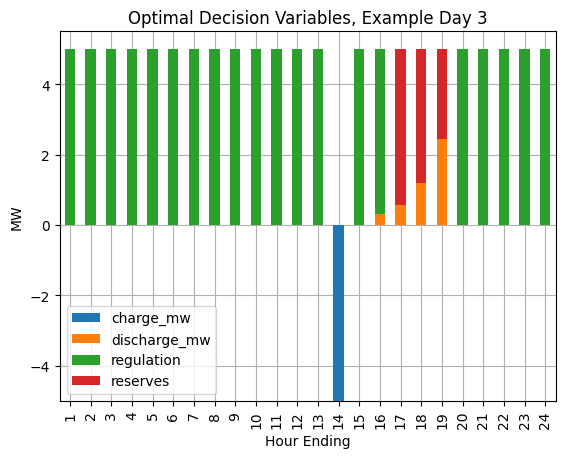

In [52]:
opt_df.drop(['SOC','charging_flag','discharging_flag'],axis=1).plot(x='time',kind='bar',stacked=True,zorder=3)
plt.grid(zorder=0)
plt.xlabel('Hour Ending')
plt.ylabel('MW')
plt.title('Optimal Decision Variables, Example Day '+str(example_day))
plt.legend().set_title(None)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

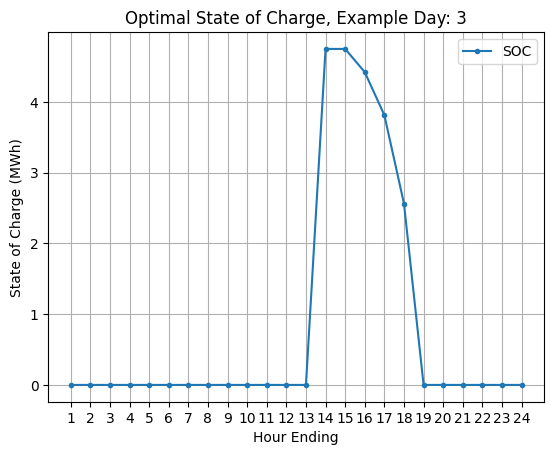

In [53]:
# plot state of charge over the operating day
plt_opt = opt_df.plot(x='time', y='SOC',kind='line', style='.-')
plt.xticks(range(1,t_max+1))
plt.xlabel('Hour Ending')
plt.ylabel('State of Charge (MWh)')
plt.title('Optimal State of Charge, Example Day: '+str(example_day))
plt.grid(zorder=0)
plt.show